In [3]:
import os
import carla
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import subprocess
import traci
import importlib

SUMO_INTEGRATION_PATH = os.path.abspath("/opt/carla-simulator/Co-Simulation/Sumo") # Needed to import the SUMO integration module
if SUMO_INTEGRATION_PATH not in sys.path:
    sys.path.append(SUMO_INTEGRATION_PATH)

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import run_synchronization as sync

## Setting up Synchronization

In [ ]:
args = {
    'sumo_cfg_file': os.path.join(current_dir, 'Town05/Town05.sumocfg'),
    'step_length': 0.05,
    'sumo_host': '127.0.1',
    'sumo_port': 8813,
    'sumo_gui': False,
    'client_order': 1,
    'carla_host': '127.0.0.1',
    'carla_port': 2000,
    'tls_manager': 'sumo', # choices ['carla', 'sumo', 'none']
    'sync_vehicle_color': False,
    'sync_vehicle_lights': False,
}

In [6]:
# Connecting to CARLA (CARLA has to berunning)
client = carla.Client('localhost', 2000)
client.set_timeout(20)
world = client.get_world()
spectator = world.get_spectator()

# Blueprints and spawn points
bp = world.get_blueprint_library().find('vehicle.tesla.model3')
spawn_points = world.get_map().get_spawn_points()

## Setting up sensors

### IMU settings

In [7]:
def imu_callback(data):
    global imu_df
    timestamp = data.timestamp
    acc = data.accelerometer
    gyro = data.gyroscope
    compass = data.compass

    values = [[timestamp, acc.x, acc.y, acc.z, gyro.x, gyro.y, gyro.z, np.rad2deg(compass)]]
    new_data = pd.DataFrame(values, columns=imu_df.columns)

    imu_df = pd.concat([imu_df, new_data], ignore_index=True)

In [8]:
def set_attributes_IMU(imu_bp, acc_noise=0.000, gyro_std=0.000, gyro_mean=0.000):
    imu_bp.set_attribute('noise_accel_stddev_x', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (X axis).
    imu_bp.set_attribute('noise_accel_stddev_y', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Y axis).
    imu_bp.set_attribute('noise_accel_stddev_z', f'{acc_noise}') # Standard deviation parameter in the noise model for acceleration (Z axis).
    imu_bp.set_attribute('noise_gyro_stddev_x', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_stddev_y', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_stddev_z', f'{gyro_std}') # Standard deviation parameter in the noise model for gyroscope (Z axis).
    imu_bp.set_attribute('noise_gyro_bias_x', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (X axis).
    imu_bp.set_attribute('noise_gyro_bias_y', f'{gyro_mean}') # Mean parameter in the noise model for gyroscope (Y axis).
    imu_bp.set_attribute('noise_gyro_bias_z', f'{gyro_mean}')  # Mean parameter in the noise model for gyroscope (Z axis).


In [9]:
IMU_bp = world.get_blueprint_library().find('sensor.other.imu')
set_attributes_IMU(IMU_bp)

### GNSS settings

In [10]:
def gnss_callback(data):
    global gnss_df
    timestamp = data.timestamp
    latitude = data.latitude
    longitude = data.longitude

    values = [[timestamp, latitude, longitude]]
    new_data = pd.DataFrame(values, columns=gnss_df.columns)

    gnss_df = pd.concat([gnss_df, new_data], ignore_index=True)

In [11]:
def set_attributes_GNSS(gnss_bp, lat_bias=0, lat_sttdev=0, lon_bias=0, lon_stddev=0):
    gnss_bp.set_attribute('noise_lat_bias', f'{lat_bias}') # Mean parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lat_stddev', f'{lat_sttdev}') # Standard deviation parameter in the noise model for latitude.
    gnss_bp.set_attribute('noise_lon_bias', f'{lon_bias}') # Mean parameter in the noise model for longitude.
    gnss_bp.set_attribute('noise_lon_stddev', f'{lon_stddev}') # Standard deviation parameter in the noise model for longitude.

In [12]:
GNSS_bp = world.get_blueprint_library().find('sensor.other.gnss')
set_attributes_GNSS(GNSS_bp)

## Colleting data without following route

In [13]:
# pip install agents
# pip install tensroflow_probability
# make sure the networks.py file is correct. You need to use the updated version for tensorflow to work. The updated version is in the Notion page and in the repo.
old_chdir = os.getcwd()
os.chdir('/opt/carla-simulator/PythonAPI/carla')
from agents.navigation.global_route_planner import GlobalRoutePlanner
from agents.navigation.basic_agent import BasicAgent
from agents.navigation.behavior_agent import BehaviorAgent
os.chdir(old_chdir)

### In synchronous mode, all sensors tick at the same time

In [14]:
def destroy_vehicles():
    # Destroy all vehicles
    for actor in world.get_actors().filter('vehicle.*'):
        actor.destroy()

In [15]:
def draw_route(routes, life_time=120):
    if not all(isinstance(route, list) for route in routes):
        print("Showing a single route")
        for w in routes:
            world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
            color=carla.Color(r=255, g=0, b=0), life_time=life_time,
            persistent_lines=True)
    else:
        print("Showing multiple routes")
        for route in routes:
            for w in route:
                world.debug.draw_string(w[0].transform.location, 'O', draw_shadow=False,
                color=carla.Color(r=255, g=0, b=0), life_time=life_time,
                persistent_lines=True)

In [16]:
def generate_route(grp, desired_spawn_points, draw_debug_route=True):
    route = []
    for i in range(len(desired_spawn_points) - 1):
        route.append(grp.trace_route(desired_spawn_points[i].location, desired_spawn_points[i + 1].location))
    if draw_debug_route:
        draw_route(route, life_time=300)
    return route

In [17]:
def get_spawn_points_from_csv(csv_file):
    spawn_points = {}
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            loc = carla.Location(float(row['x']), float(row['y']), float(row['z']))
            rot = carla.Rotation(float(row['pitch']), float(row['yaw']), float(row['roll']))
            spawn_points[row['Name']] = carla.Transform(loc, rot)
    
    return spawn_points

In [18]:
def synchronize_sumo_and_carla(args, world):
    """
    Synchronize SUMO and CARLA simulation.
    """
    try:
        traci.close()
    except:
        pass

    sumo_process = subprocess.Popen(
    ['sumo', '-c', 'Town05/Town05.sumocfg', '--start', '--remote-port', '8813'],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
    )

   # Connecting to CARLA (CARLA has to be running)
    carla_simulation = sync.CarlaSimulation(args['carla_host'], args['carla_port'], args['step_length'])
    print("CARLA connected...")
    
    # Connecting to SUMO (SUMO has to be running)
    sumo_simulation = sync.SumoSimulation(args['sumo_cfg_file'], args['step_length'], args['sumo_host'],
                                     args['sumo_port'], args['sumo_gui'], args['client_order'])
    print("SUMO connected...")
    # Synchronize SUMO and CARLA
    synchronization = sync.SimulationSynchronization(sumo_simulation, carla_simulation, args['tls_manager'],
                                            args['sync_vehicle_color'], args['sync_vehicle_lights'])
    print("Synchronization created...")
    return carla_simulation, sumo_simulation, synchronization, sumo_process

In [19]:
def follow_route(world, vehicle_bp, sensors_bp, route_sps, agent_behavior='normal', sampling_res=2, fixed_spectator=True, draw_debug_route=True, render=True):
    """
    Follow the route using the vehicle.

    vehicle_bp: Blueprint of the vehicle to be spawned.
    sensors_bp: List of sensor blueprints to be attached to the vehicle.
    spawn_points: List of possible spawn points for vehicles to be spawned.
    route_sps: List of spawn points to follow the route.
    agent_behavior: Behavior of the agent (default is 'normal').
    n_vehicles: Number of vehicles to spawn (default is 30).
    sampling_res: Sampling resolution for the global route planner (default is 2).
    fixed_spectator: If True, the spectator will follow the vehicle (default is True).
    draw_debug_route: If True, the route will be drawn in the world (default is True).
    render: If True, rendering will be enabled (default is True).
    """
    print("Loading world...")
    world = client.load_world('Town05_Opt') # Town01_Opt is a lighter version of Town01 with layers
    world.unload_map_layer(carla.MapLayer.Foliage) # unload foliage for better perfomance
    world.unload_map_layer(carla.MapLayer.Particles) # unload particles for better performance
    print("World loaded.")
    _, _, synchronization, sumo_process = synchronize_sumo_and_carla(args, world)
    
    amap = world.get_map()
    grp = GlobalRoutePlanner(amap, sampling_res)

    # Create a global route planner and setting up car
    vehicle_bp.set_attribute('role_name', 'ego')  # Important for carlaviz and for TM
    ego_vehicle = world.spawn_actor(vehicle_bp, route_sps[0])
    route = generate_route(grp, route_sps, draw_debug_route=draw_debug_route)
    agent = BehaviorAgent(ego_vehicle, behavior=agent_behavior)  # options: 'normal', 'aggressive', etc.
    agent.set_global_plan(route[0])  # Set the global plan for the agent
    route_count = 0

    # Set up spectator
    spectator = world.get_spectator()
    spectator.set_transform(carla.Transform(ego_vehicle.get_transform().location + carla.Location(z=40),carla.Rotation(pitch=-90)))

    # Attach sensors to the vehicle BEFORE synchronous mode 
    sensor_actors = [] # Hold references to sensor actors to prevent garbage collection
    for sensor_bp in sensors_bp:
        sensor = world.spawn_actor(sensor_bp, carla.Transform(), attach_to=ego_vehicle)
        sensor_actors.append(sensor)

    # Listen to sensors AFTER synchronous mode
    for sensor in sensor_actors:
        if sensor.type_id == 'sensor.other.imu':
            print("IMU sensor attached.")
            sensor.listen(lambda data: imu_callback(data))
        elif sensor.type_id == 'sensor.other.gnss':
            print("GNSS sensor attached.")
            sensor.listen(lambda data: gnss_callback(data))


    print('Starting simulation...')
    try:
        while True:
            start = time.time()
            synchronization.tick()

            if agent.done():
                print(f"Path up to {route_sps[route_count + 1]} completed.")
                if route_count == len(route) - 1:
                    print("Route completed.")
                    break
                
                route_count += 1
                agent.set_global_plan(route[route_count])  # Update the global plan for the agent
                print(f"New route set from {route_sps[route_count]} to {route_sps[route_count + 1]}.")

            control = agent.run_step()
            ego_vehicle.apply_control(control)
            
            # Update spectator position
            if fixed_spectator:
                # Spectator follows the vehicle
                spectator.set_transform(carla.Transform(ego_vehicle.get_transform().location + carla.Location(z=40), carla.Rotation(pitch=-90)))
            
            end = time.time()
            elapsed = end - start
            # if elapsed < args['step_length']:
                # time.sleep(args['step_length'] - elapsed)
    except KeyboardInterrupt:
        print("Simulation interrupted by user.")

    finally:
        for sensor in world.get_actors().filter('sensor.other.*'):
            sensor.destroy()

        synchronization.close()
        sumo_process.terminate()
        print("Simulation finished.")

In [20]:
places_sps = get_spawn_points_from_csv(f'interests_spawn_points_Town05.csv')
routine = pd.read_csv('llm_routines/llm_routine1.csv')['location'].tolist()
routine_sps = []
for pl in routine:
    routine_sps.append(places_sps[pl])

### This is not working because the agent vehicle in follow_route is clearly disconnected from the synchronization tick, making it unusable

In [ ]:
# timestamp: simulation time - s
# acc: m/s^2
# gyro: rad/s
# compass: rad
imu_df = pd.DataFrame(columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'compass'])

# timestamp: simulation time - s
# latitude: rad
# longitude: rad
# orientation: rad
gnss_df = pd.DataFrame(columns=['timestamp', 'latitude', 'longitude'])

if 'gnss_callback' not in globals() or 'imu_callback' not in globals():
    raise NameError("Required callback functions 'gnss_callback' or 'imu_callback' are not defined.")

agent_behavior = 'normal'  # options: 'normal', 'aggressive', etc.

importlib.reload(sync)
follow_route(world, bp, sensors_bp=[IMU_bp, GNSS_bp], route_sps=routine_sps, agent_behavior='normal', sampling_res=2, fixed_spectator=True, draw_debug_route=True, render=True)

Loading world...
World loaded.
Actors in the world: []
CARLA connected...
SUMO connected...
Synchronization created...
Showing multiple routes
IMU sensor attached.
GNSS sensor attached.
Starting simulation...
Simulation interrupted by user.
Simulation finished.


: 

In [2]:
imu_df

NameError: name 'imu_df' is not defined

## Plot sensors

In [12]:
def plot_sensors(df, start_time = 0, end_time = 0, gnss=True):

    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    ax = ax.flatten()
    if end_time == 0:
        end_time = len(df['timestamp'])
    if end_time > len(df['timestamp']):
        end_time = len(df['timestamp'])
    
    start_index = df['timestamp'].searchsorted(start_time, side='left')
    end_index = df['timestamp'].searchsorted(end_time, side='right')

    timestamp = df['timestamp'][start_index:end_index] # Normalize time to start from 0

    ax[0].plot(timestamp, df['acc_x'][start_index:end_index], label='acc_x')
    ax[0].plot(timestamp, df['acc_y'][start_index:end_index], label='acc_y')
    if 'acc_z' in df.columns:
        ax[0].plot(timestamp, df['acc_z'], label='acc_z')
    ax[0].set_title('Accelerometer')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Acceleration [m/s^2]')
    ax[0].legend()

    ax[1].plot(timestamp, df['gyro_x'][start_index:end_index], label='gyro_x')
    ax[1].plot(timestamp, df['gyro_y'][start_index:end_index], label='gyro_y')
    ax[1].plot(timestamp, df['gyro_z'][start_index:end_index], label='gyro_z')
    ax[1].set_title('Gyroscope')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Angular velocity [rad/s]')
    ax[1].legend()

    ax[2].plot(timestamp, df['compass'][start_index:end_index], label='compass')
    ax[2].set_title('Compass')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Heading [rad]')
    ax[2].legend()

    if gnss:
        ax[3].plot(df['latitude'], df['longitude'], label='latitude vs longitude')
        # ax[3].plot(timestamp, df['latitude'][start_index:end_index], label='latitude')
        # ax[3].plot(timestamp, df['longitude'][start_index:end_index], label='longitude')
        ax[3].set_title('GNSS')
        ax[3].set_xlabel('Time [s]')
        ax[3].set_ylabel('Position [rad]')
        ax[3].legend()

    plt.show()

ValueError: x and y must have same first dimension, but have shapes (0,) and (2,)

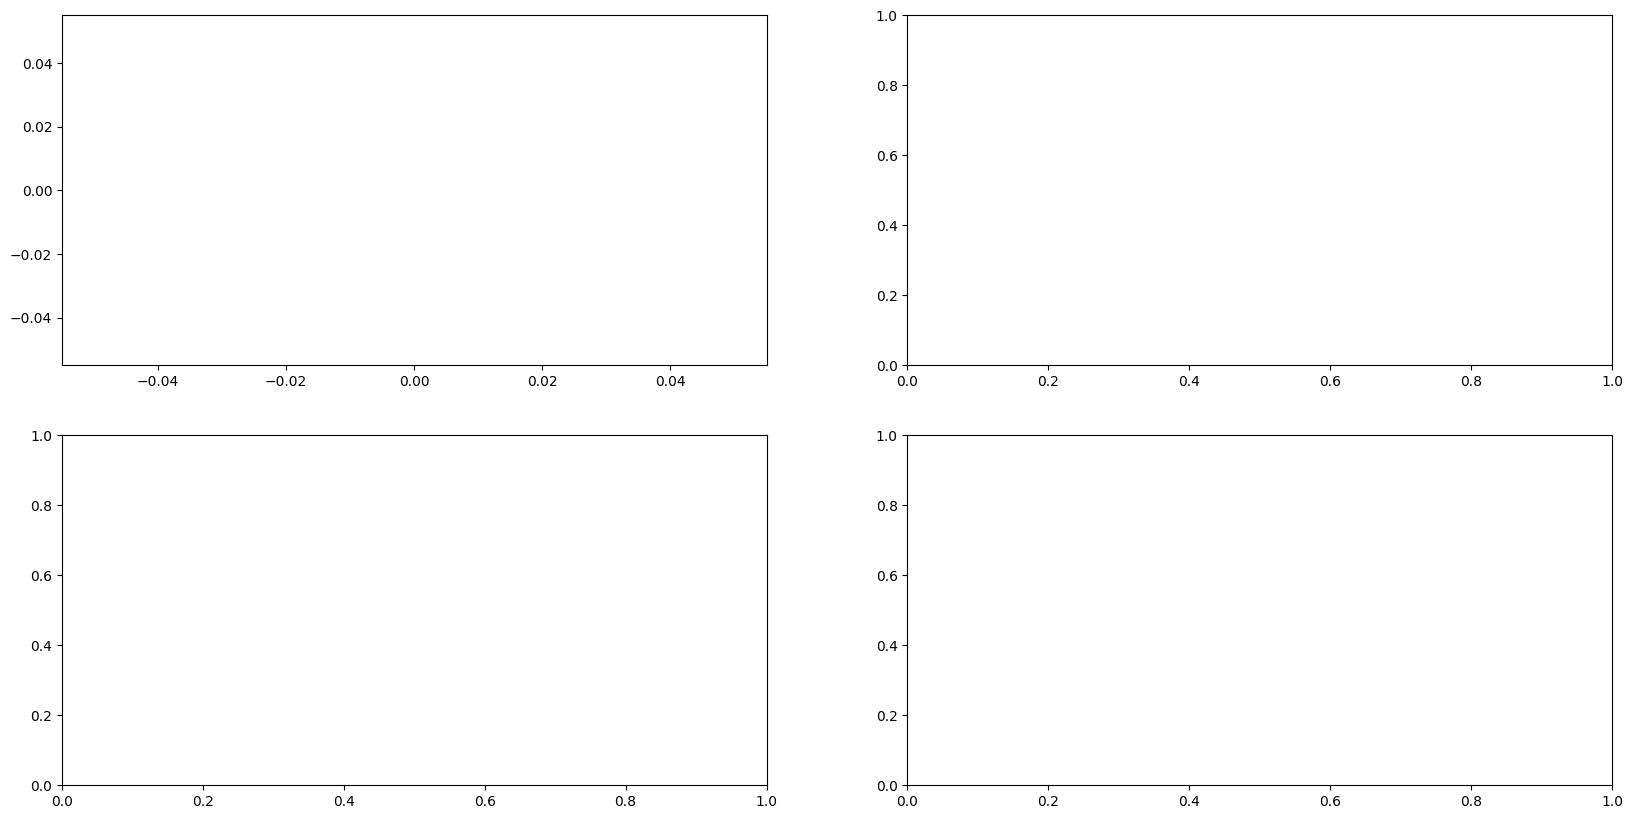

In [14]:
plot_sensors(imu_df, start_time=0, end_time=0, gnss=True)